In [ ]:
! pip3 install transformers

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.5 MB 60.6 MB/s 
     |████████████████████████████████| 77 kB 9.1 MB/s 
     |████████████████████████████████| 596 kB 69.6 MB/s 
     |████████████████████████████████| 895 kB 62.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

from transformers import (
    AutoTokenizer, 
    AutoModel,
    get_linear_schedule_with_warmup,
    BertModel,
    BertTokenizer,
    BertTokenizerFast
)

In [ ]:
import json
import pandas as pd
import numpy as np
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
citation = pd.DataFrame(columns=['Text_Tokens','Cit_func','citseg_id'])
citation

,Text_Tokens,Cit_func,citseg_id


In [ ]:
import os
paths=[]
#d = "/content/per_func_map_organised_small_11class/all"
d="/content/drive/MyDrive/per_func_map_organised_small_11class/all"
for path in os.listdir(d):
    full_path = os.path.join(d, path)
    if os.path.isfile(full_path):
        paths.append(full_path)

**Reading Data from dataset**

In [ ]:
for i in range(len(paths)):
  path = paths[i]
  print(path)
  f=open(path)
  data=json.load(f)
  for i in data.values():
    citation_contexts=i['citation_contexts']
    for j in range(len(citation_contexts)):
      a=[]
      tokens=citation_contexts[j]['citance']['tokens_pp']
      for cit_refs in range(len(citation_contexts[j]['cit_refs'])):
         citseg_id=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
         if citseg_id not in  a:
            a.append(citseg_id)
            c=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
            f=citation_contexts[j]['cit_refs'][cit_refs]['function_agreed']
            citation = citation.append({'Text_Tokens':tokens, 'Cit_func':f,'citseg_id':c},ignore_index=True)

/content/drive/MyDrive/per_func_map_organised_small_11class/all/Future.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Support.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Basis.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoGM.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoRes.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoXY.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Motivation.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Neutral.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Similar.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_sm

**Joining Tokens of text**

In [ ]:
df=citation['Text_Tokens'].tolist()
str1 = [' '.join([str(i) for i in y]) for y in df]
citation['text']=str1

In [ ]:
citation.head()

,Text_Tokens,Cit_func,citseg_id,text
0,"[For, example, ,, it, would, be, helpful, to, consider, strong, correspondence, between, certain, English, and, Chinese, words, ,, as, in, (, CITSEG, ), .]",Future,21,"For example , it would be helpful to consider strong correspondence between certain English and Chinese words , as in ( CITSEG ) ."
1,"[Since, task, initiative, models, contribution, to, domain, /, problemsolving, goals, ,, while, dialogue, initiative, affects, the, cur, -5, An, alternative, strategy, to, step, (, 4, ), is, to, perform, a, database, lookup, based, on, the, ambiguous, query, and, summarize, the, results, (, CITSEG, ), ,, which, we, leave, for, future, work, .]",Future,42,"Since task initiative models contribution to domain / problemsolving goals , while dialogue initiative affects the cur -5 An alternative strategy to step ( 4 ) is to perform a database lookup based on the ambiguous query and summarize the results ( CITSEG ) , which we leave for future work ."
2,"[We, perceive, that, these, results, can, be, extended, to, other, language, models, that, properly, embed, bilexical, context, -, free, grammars, ,, as, for, instance, the, more, general, history, -, based, models, used, in, (, CITSEG, ), and, (, CITSEG, ), .]",Future,34,"We perceive that these results can be extended to other language models that properly embed bilexical context - free grammars , as for instance the more general history - based models used in ( CITSEG ) and ( CITSEG ) ."
3,"[We, perceive, that, these, results, can, be, extended, to, other, language, models, that, properly, embed, bilexical, context, -, free, grammars, ,, as, for, instance, the, more, general, history, -, based, models, used, in, (, CITSEG, ), and, (, CITSEG, ), .]",Future,38,"We perceive that these results can be extended to other language models that properly embed bilexical context - free grammars , as for instance the more general history - based models used in ( CITSEG ) and ( CITSEG ) ."
4,"[We, also, propose, to, consider, aspects, of, reviews, (, CITSEG, ), ,, and, investigate, other, methods, that, measure, class, similarity, ,, such, as, selecting, typical, instances, (, CITSEG, ), .]",Future,9,"We also propose to consider aspects of reviews ( CITSEG ) , and investigate other methods that measure class similarity , such as selecting typical instances ( CITSEG ) ."


**Visualising Citation Function Present**

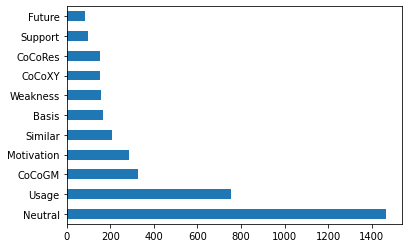

In [ ]:
citation.Cit_func.value_counts().plot(kind='barh')

In [ ]:
display(citation.Cit_func.value_counts())             
print(" ")

Neutral       1463
Usage          755
CoCoGM         328
Motivation     288
Similar        207
Basis          167
Weakness       158
CoCoXY         152
CoCoRes        151
Support        100
Future          85
Name: Cit_func, dtype: int64

**Dropping some rows of Neutral and Usage functions**

In [ ]:
citation.drop(citation.query('Cit_func == "Neutral" ').sample(n=400).index,inplace=True)
citation.drop(citation.query('Cit_func == "Usage" ').sample(n=100).index,inplace=True)

**Converting 11 labels to 6 labels**

In [ ]:
citation['Cit_func'].replace({'Support':'Comparison or Contrast','Neutral':'Background','CoCoXY':'Background','Weakness':'Comparison or Contrast',
                                    'CoCoGM':'Comparison or Contrast','Usage':'Uses','Basis':'Extends','CoCoRes':'Comparison or Contrast',
                                    'Similar':'Comparison or Contrast'}, inplace=True)

In [ ]:
unique_labels = citation.Cit_func.unique()
unique_labels

array(['Future', 'Comparison or Contrast', 'Extends', 'Background',
       'Motivation', 'Uses'], dtype=object)

**One- hot encoding for labels**

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(unique_labels)

citation['label'] = le.transform(citation.Cit_func)

In [ ]:
#Shuffling the dataframe
citation = citation.sample(frac=1).reset_index(drop=True)

**Splitting the dataset**

In [ ]:
#split the subset by rating to create new train, val and test splits
import collections
by_rating = collections.defaultdict(list)
for _,row in citation.iterrows():
  by_rating[row.Cit_func].append(row.to_dict())

In [ ]:
#create split data
seed =1021
final_list = []
np.random.seed(seed)
train_proportion = 0.7
val_proportion = 0.2
test_proportion = 0.1


for _, item_list in sorted(by_rating.items()):
  np.random.shuffle(item_list)

  n_total = len(item_list)
  n_train = int(train_proportion * n_total)
  n_val = int(val_proportion * n_total)
  n_test = int(test_proportion * n_total)


  #give data points  split attribute

  for item in item_list[:n_train]:
    item['split'] = 'train'

  for item in item_list[n_train:n_train+n_val]:
    item['split'] = 'val'

  for item in item_list[n_train+n_val:n_train+n_val+n_test]:
   item['split'] = 'test'


  #Add to final list

  final_list.extend(item_list)


citation = pd.DataFrame(final_list)

In [ ]:
citation.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split
0,"[Multi-source, methods, combine, lexical, cohesion, with, other, indicators, of, topic, shift, such, as, cue, phrases, ,, prosodic, features, ,, reference, ,, syntax, and, lexical, attraction, (, CITSEG, ), using, decision, trees, (, CITSEG, ), and, probabilistic, models, (, CITSEG, ), .]",Background,38,"Multi-source methods combine lexical cohesion with other indicators of topic shift such as cue phrases , prosodic features , reference , syntax and lexical attraction ( CITSEG ) using decision trees ( CITSEG ) and probabilistic models ( CITSEG ) .",0,train
1,"[CITSEG, provides, an, account, of, LFG, semantics, that, represents, the, meaning, of, lexical, items, with, linear, logic, formulas, .]",Background,0,CITSEG provides an account of LFG semantics that represents the meaning of lexical items with linear logic formulas .,0,train
2,"[The, [, CITSEG, ], centering, model, is, based, on, the, following, assumptions, .]",Background,2,The [ CITSEG ] centering model is based on the following assumptions .,0,train
3,"[Word, Sense, Disambiguation, (, WSD, ), is, wellknown, as, one, of, the, more, difficult, problems, in, the, field, of, natural, language, processing, ,, as, noted, in, (, CITSEG, ), ,, and, others, .]",Background,27,"Word Sense Disambiguation ( WSD ) is wellknown as one of the more difficult problems in the field of natural language processing , as noted in ( CITSEG ) , and others .",0,train
4,"[The, uses, of, this, procedure, include, information, retrieval, (, CITSEG, ), ,, summarization, (, CITSEG, ), ,, text, understanding, ,, anaphora, resolution, (, CITSEG, ), ,, language, modelling, (, CITSEG, ), and, improving, document, navigation, for, the, visually, disabled, (, CITSEG, ), .]",Background,40,"The uses of this procedure include information retrieval ( CITSEG ) , summarization ( CITSEG ) , text understanding , anaphora resolution ( CITSEG ) , language modelling ( CITSEG ) and improving document navigation for the visually disabled ( CITSEG ) .",0,train


**Some visualizations after splitting the Dataset**

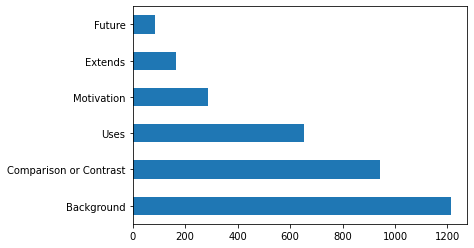

In [ ]:
citation.Cit_func.value_counts().plot(kind='barh')

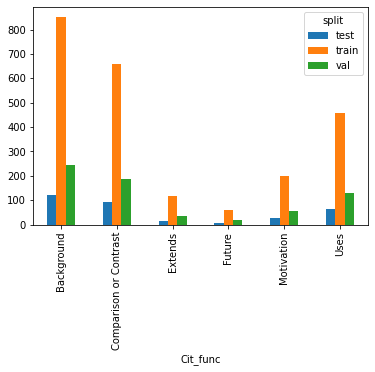

In [ ]:
citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a=citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a.plot(kind='bar')

In [ ]:
citation.groupby(['Cit_func','split']).size()

Cit_func                split
Background              test     121
                        train    850
                        val      243
Comparison or Contrast  test      94
                        train    660
                        val      188
Extends                 test      16
                        train    116
                        val       33
Future                  test       8
                        train     59
                        val       17
Motivation              test      28
                        train    201
                        val       57
Uses                    test      65
                        train    458
                        val      131
dtype: int64

**Tokenizer**

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizerFast.from_pretrained('/content/drive/MyDrive/scibert_scivocab_uncased')
special_tokens_dict = {'additional_special_tokens': ['CITSEG']}
tokenizer.add_special_tokens(special_tokens_dict=special_tokens_dict)

Loading BERT tokenizer...


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


0

**Splitting the dataset into three datasets: train, val, test**

In [ ]:
df_train = citation[citation.split=='train']
df_val = citation[citation.split=='val']
df_test= citation[citation.split=='test']

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(2344, 6)
(669, 6)
(332, 6)


**Shuffling the data splits**

In [ ]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

**Getting texts and labels**

In [ ]:
sentences_train = df_train.text.values
labels_train = df_train.label.values

sentences_valid = df_val.text.values
labels_valid = df_val.label.values

sentences_test = df_test.text.values
labels_test = df_test.label.values

**Creating input ids, attention masks**

In [ ]:
from keras.preprocessing.sequence import pad_sequences
def create_input_ids_attention_maks(sentences, max_len):
  input_ids = []

  # For every sentence...
  for sent in sentences:
      # `encode` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      encoded_sent = tokenizer.encode(
                          sent,                      
                          add_special_tokens = True,
                          max_length = max_len,         
                          truncation=True
                          
                    )
      
      # Add the encoded sentence to the list.
      input_ids.append(encoded_sent)

  
  # pad the sequences
  input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", 
                            value=0, truncating="post", padding="post")
  

  # Create attention masks
  attention_masks = []

  for sent in input_ids:
      
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in sent]
      
      attention_masks.append(att_mask)

  return [input_ids, attention_masks]

In [ ]:
input_ids_train, attention_masks_train = create_input_ids_attention_maks(sentences_train, 200)
input_ids_valid, attention_masks_valid = create_input_ids_attention_maks(sentences_valid, 200)
input_ids_test, attention_masks_test = create_input_ids_attention_maks(sentences_test, 200)

In [ ]:
input_ids_train.shape

(2344, 200)

**Calculating position of Citseg in tokenised text**

In [ ]:
def calc_tok_cit_seg_id(df,input_id):
  cit_id=df['citseg_id'].values
  k=0
  tok_cid=[]
  for i in input_id:
    cit_seg_tok_id=-1
    #print(i)
    for j in i:
      #print(j)

      cit_seg_tok_id +=1
      if (j==1 and cit_seg_tok_id>= cit_id[k]):
        if(cit_seg_tok_id!= None):
          #print("cit_seg_tok_id for ", k ,"is: ", cit_seg_tok_id)
          tok_cid.append(cit_seg_tok_id)
          #print(k,len(tok_cid))
        else:
          print("no citseg")
        break
    k+=1
  #print(k)
  return tok_cid

In [ ]:
id_train= calc_tok_cit_seg_id(df_train,input_ids_train)
id_val= calc_tok_cit_seg_id(df_val,input_ids_valid) 
id_test= calc_tok_cit_seg_id(df_test,input_ids_test)

In [ ]:
len(id_train)

2344

**Adding Citseg position to Dataframes**

In [ ]:
df_train.loc[:,'tok_citseg_id']=id_train
df_test['tok_citseg_id']=id_test
df_val.loc[:,'tok_citseg_id']=id_val

In [ ]:
df_train.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[This, stands, in, contrast, to, the, analysis, of, CITSEG, ,, which, presumes, that, people, are, applying, some, higher, -, level, reasoning, to, "", correct, "", an, ill-formed, statement, in, the, case, of, the, "", no, "", in, -, terpretation, .]",Comparison or Contrast,8,"This stands in contrast to the analysis of CITSEG , which presumes that people are applying some higher - level reasoning to "" correct "" an ill-formed statement in the case of the "" no "" in - terpretation .",1,train,9
1,"[The, approach, described, in, (, CITSEG, ), is, very, similar, to, ours, :, in, this, study, ,, the, authors, propose, to, find, and, analyze, the, limits, of, machine, translation, systems, by, studying, the, reference, reachability, .]",Comparison or Contrast,5,"The approach described in ( CITSEG ) is very similar to ours : in this study , the authors propose to find and analyze the limits of machine translation systems by studying the reference reachability .",1,train,6
2,"[Provided, with, the, candidate, fragment, elements, ,, we, previously, (, CITSEG, ), used, a, chunker, 3, to, finalize, the, output, fragments, ,, in, order, to, follow, the, linguistic, definition, of, a, (, para, -, ), phrase, .]",Extends,10,"Provided with the candidate fragment elements , we previously ( CITSEG ) used a chunker 3 to finalize the output fragments , in order to follow the linguistic definition of a ( para - ) phrase .",2,train,11
3,"[Other, systems, (, CITSEG, ), also, look, at, Web, product, reviews, but, they, do, not, extract, opinions, about, particular, product, features, .]",Comparison or Contrast,3,Other systems ( CITSEG ) also look at Web product reviews but they do not extract opinions about particular product features .,1,train,4
4,"[We, used, four, classifiers, to, learn, every, development, set, :, (, 1, ), Support, Vector, Machine, ,, (, 2, ), Ada, Boost, ,, (, 3, ), Multilayer, Perceptron, (, MLP, ), and, (, 4, ), Decision, Tree, using, the, open, source, WEKA, Data, Mining, Software, (, CITSEG, ), .]",Uses,46,"We used four classifiers to learn every development set : ( 1 ) Support Vector Machine , ( 2 ) Ada Boost , ( 3 ) Multilayer Perceptron ( MLP ) and ( 4 ) Decision Tree using the open source WEKA Data Mining Software ( CITSEG ) .",5,train,49


In [ ]:
df_val.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[The, first, heuristic, prefers, evidence, in, which, the, system, is, most, confident, since, high, -, quality, evidence, produces, more, attitude, change, than, any, other, evidence, form, (, CITSEG, ), .]",Background,27,The first heuristic prefers evidence in which the system is most confident since high - quality evidence produces more attitude change than any other evidence form ( CITSEG ) .,0,val,29
1,"[Following, CITSEG, we, have, implemented, a, transformation, -, based, learning, (, TBL, ), algorithm, (, CITSEG, ), .]",Uses,15,Following CITSEG we have implemented a transformation - based learning ( TBL ) algorithm ( CITSEG ) .,5,val,17
2,"[Although, performance, is, often, reasonable, in, controlled, environments, (, such, as, studio, news, rooms, ), ,, automatic, speech, recognition, (, ASR, ), systems, have, significant, difficulty, in, noisier, settings, (, such, as, those, found, in, live, sports, broadcasts, ), (, CITSEG, ), .]",Comparison or Contrast,40,"Although performance is often reasonable in controlled environments ( such as studio news rooms ) , automatic speech recognition ( ASR ) systems have significant difficulty in noisier settings ( such as those found in live sports broadcasts ) ( CITSEG ) .",1,val,45
3,"[In, future, work, we, plan, to, experiment, with, richer, representations, ,, e.g., including, long, -, range, n-grams, (, CITSEG, ), ,, class, n-grams, (, CITSEG, ), ,, grammatical, features, (, CITSEG, ), ,, etc, ', .]",Future,24,"In future work we plan to experiment with richer representations , e.g. including long - range n-grams ( CITSEG ) , class n-grams ( CITSEG ) , grammatical features ( CITSEG ) , etc ' .",3,val,24
4,"[In, processing, the, HOLJ, documents, we, have, built, a, pipeline, using, as, key, components, the, programs, distributed, with, the, LT, TTT, and, LT, XML, toolsets, (, CITSEG, ), ,, (, CITSEG, ), and, the, xmlperl, program, (, CITSEG, ), .]",Uses,37,"In processing the HOLJ documents we have built a pipeline using as key components the programs distributed with the LT TTT and LT XML toolsets ( CITSEG ) , ( CITSEG ) and the xmlperl program ( CITSEG ) .",5,val,43


In [ ]:
df_test.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[Though, several, studies, with, similar, objectives, have, been, reported, [, CITSEG, ], ,, [, CITSEG, ], ,, [, CITSEG, ], ,, [, CITSEG, ], ,, [, CITSEG, ], ,, [, CITSEG, ], ,, they, require, that, sample, corpora, be, correctly, analyzed, or, tagged, in, advance, .]",Comparison or Contrast,30,"Though several studies with similar objectives have been reported [ CITSEG ] , [ CITSEG ] , [ CITSEG ] , [ CITSEG ] , [ CITSEG ] , [ CITSEG ] , they require that sample corpora be correctly analyzed or tagged in advance .",1,test,31
1,"["", CITSEG, and, Church, &, Hanks, (, 1990, ), describe, algorithms, which, do, this, .]",Comparison or Contrast,1,""" CITSEG and Church & Hanks ( 1990 ) describe algorithms which do this .",1,test,2
2,"[We, used, a, discriminative, word, alignment, model, (, DWA, ), to, generate, the, alignments, as, described, in, CITSEG, instead, .]",Uses,17,We used a discriminative word alignment model ( DWA ) to generate the alignments as described in CITSEG instead .,5,test,19
3,"[Lexicalist, approaches, to, MT, ,, particularly, those, incorporating, the, technique, of, Shake, -, and, -, Bake, generation, (, CITSEG, ), ,, combine, the, linguistic, advantages, of, transfer, (, CITSEG, ), and, interlingual, (, CITSEG, ), approaches, .]",Motivation,18,"Lexicalist approaches to MT , particularly those incorporating the technique of Shake - and - Bake generation ( CITSEG ) , combine the linguistic advantages of transfer ( CITSEG ) and interlingual ( CITSEG ) approaches .",4,test,22
4,"[Most, other, work, on, clustering, for, language, modeling, (, e.g., CITSEG, ), has, addressed, the, problem, of, data, sparseness, by, clustering, words, into, classes, which, are, then, used, to, predict, smoothed, probabilities, of, occurrence, for, events, which, may, seldom, or, never, have, been, observed, during, training, .]",Comparison or Contrast,10,Most other work on clustering for language modeling ( e.g. CITSEG ) has addressed the problem of data sparseness by clustering words into classes which are then used to predict smoothed probabilities of occurrence for events which may seldom or never have been observed during training .,1,test,14


**Create torch tensors required for DataLoader**

In [ ]:
train_inputs = torch.tensor(input_ids_train)
validation_inputs = torch.tensor(input_ids_valid)
test_inputs = torch.tensor(input_ids_test)

train_labels = torch.tensor(df_train.label.values)
validation_labels = torch.tensor(df_val.label.values)
test_labels = torch.tensor(df_test.label.values)

train_masks = torch.tensor(attention_masks_train)
validation_masks = torch.tensor(attention_masks_valid)
test_masks = torch.tensor(attention_masks_test)

citseg_train_inputs=torch.tensor(id_train)
citseg_validation_inputs=torch.tensor(id_val)
citseg_test_inputs=torch.tensor(id_test)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn

batch_size = 16


# DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels,citseg_train_inputs)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,citseg_validation_inputs)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels,citseg_test_inputs)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Custom SciBert Model**

In [ ]:
#Create custom scibert model for sequence classification
class CustomSciBERTModel(nn.Module):
    def __init__(self):
      super(CustomSciBERTModel, self).__init__()
      self.scibert = BertModel.from_pretrained('/content/drive/MyDrive/scibert_scivocab_uncased')
      self.num_labels = 6
      self.dropout = nn.Dropout(0.3)
      self.fc1 = nn.Linear(768, 512)
      self.relu = nn.ReLU()
      self.fc2 = nn.Linear(512, 6)
      self.act=nn.Softmax(dim=1)
      #self.linear_layer = nn.Linear(768, 6)
     

    def forward(self, ids, mask, labels,citseg_id):
      output = self.scibert(
            input_ids=ids, 
            attention_mask=mask)
      last_hidden_states = output[0]
      
      #gather function
      batch_size,columns=ids.shape
      citseg_id = citseg_id.view(batch_size,1,1)
      citseg_id = citseg_id.repeat(1,1,768)
      pooled_states2 = torch.gather(input=last_hidden_states, dim=1, index=citseg_id)
      #print("pooled_states2:", pooled_states2)
      citseg_feature_vector = torch.squeeze(pooled_states2, dim=1)

      #logits = self.linear_layer(citseg_feature_vector) 
      #print(citseg_feature_vector.shape)
      out = self.fc1(citseg_feature_vector)
      out = self.relu(out)
      out = self.fc2(out)
      logits= self.act(out)

      loss = None
      # while training return loss and while validation/ testing resturn logits
      if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return loss
      else:
        return logits

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Create model object
model = CustomSciBERTModel()

# Get model on to GPU
model.cuda()

# Optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of epochs
epochs = 20

# training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value 
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at /content/drive/MyDrive/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is depre

In [ ]:
# Compute accuracy
def accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(pred == labels) / len(labels)

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
def macroscore(preds,labels):
  pred = np.argmax(preds, axis=1).flatten()
  labels = labels.flatten()
  val_macro_f1_score = f1_score(labels, pred, average='macro')
  return val_macro_f1_score 

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

true, pred = [], []

predictions=[]
prediction=[]
y=[]

# Store the average loss after each epoch so we can plot them.
training_loss_values = []
validation_loss_values= []

# set initial loss to infinite
best_valid_loss = float('inf')

# store predictions on validation data
valid_preds = []

max_val_f1_score=0

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains four pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        #   [3]: citseg ids 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_citseg_id=batch[3].to(device)
        

        # backward pass. PyTorch doesn't do this automatically because 
        model.zero_grad()        

        # Forward pass
        outputs = model(ids = b_input_ids, mask = b_input_mask, labels = b_labels, citseg_id=b_citseg_id)
        
        # forward pass gives loss as output
        loss = outputs

        # accumulate loss
        total_loss += loss.item()

        # backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0. to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    training_loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Reset the total validation loss for this epoch.
    total_valid_loss = 0

    # evaluation mode.
    model.eval()

    # evaluation loss and accuracy
    eval_loss, eval_accuracy = 0, 0
    running_loss, running_acc= 0 , 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels,b_citseg_id = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # It gives logits when labels are not given to model
            outputs = model(b_input_ids, 
                            b_input_mask, labels = None, citseg_id=b_citseg_id)
        
        # Get the "logits" output by the model. The "logits" are the output
        logits = outputs

        # Track the number of batches
        nb_eval_steps += 1

        # compute the loss
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, b_labels)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (nb_eval_steps)    

        # Calculate the average loss over the validating data.
        # accumulate loss
        total_valid_loss += loss.item()
        avg_valid_loss = total_valid_loss / len(validation_dataloader)
         
         #save the best model
        if avg_valid_loss < best_valid_loss:
          best_valid_loss = avg_valid_loss
          torch.save(model.state_dict(), 'saved_weights.pt') 

        

        #appending predictions and true labels for last epoch
        if(epoch_i==epochs-1):
          _, predictions = logits.max(dim=1)
          prediction.append(predictions)
          y.append(b_labels)

        #compute the accuracy
        acc_t = compute_accuracy(logits, b_labels)
        running_acc += (acc_t - running_acc) / (nb_eval_steps)


        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        valid_preds.extend(np.argmax(logits, axis=1).flatten())
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        #calculate macro f1 score
        val_f1_score=macroscore(logits, label_ids)

        if val_f1_score>max_val_f1_score:
          max_val_f1_score=val_f1_score

        

    # Store the loss value for plotting the learning curve.
    validation_loss_values.append(avg_valid_loss)
    
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Average Validation loss: {0:.2f}".format(avg_valid_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    print("The Val macro f1 score is: ", max_val_f1_score)
    print('Epoch {}\t val_loss={}\t val_acc={}'.format(epoch_i, running_loss, running_acc))
      
    

print("")
print("Training complete!")


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:13.
  Batch    80  of    147.    Elapsed: 0:00:27.
  Batch   120  of    147.    Elapsed: 0:00:40.

  Average training loss: 1.58
  Training epcoh took: 0:00:49

Running Validation...
  Accuracy: 0.55
  Average Validation loss: 1.50
  Validation took: 0:00:05
The Val macro f1 score is:  0.6202020202020201
Epoch 0	 val_loss=1.497327273800259	 val_acc=54.990842490842496

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:13.
  Batch    80  of    147.    Elapsed: 0:00:26.
  Batch   120  of    147.    Elapsed: 0:00:40.

  Average training loss: 1.43
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.60
  Average Validation loss: 1.45
  Validation took: 0:00:05
The Val macro f1 score is:  0.7666666666666666
Epoch 1	 val_loss=1.4465725961185643	 val_acc=59.901556776556774

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:0

In [ ]:
training_loss_values 

[1.576094557638882,
 1.430436826887585,
 1.3777657212043295,
 1.3463616208965277,
 1.3240183535076322,
 1.3043396108004512,
 1.280553981560428,
 1.2553970602904858,
 1.2343272911448058,
 1.2079386038034141,
 1.1847103704400614,
 1.1641954718803873,
 1.155488133430481,
 1.1488855444655126,
 1.1457290592647733,
 1.1382132525346718,
 1.1352274920664678,
 1.1370596950556957,
 1.1331822385593338,
 1.1332163405256206]

In [ ]:
validation_loss_values

[1.4973272738002597,
 1.4465725961185636,
 1.4221782003130232,
 1.4296102239972068,
 1.4292375785963876,
 1.434188147385915,
 1.4360448774837313,
 1.4104423068818592,
 1.409038469904945,
 1.3962272490773882,
 1.397603457882291,
 1.4022266637711298,
 1.4053769026483809,
 1.4006477424076624,
 1.4002901798202878,
 1.4086324884777977,
 1.4153851582890464,
 1.3910713649931408,
 1.3962250862802779,
 1.4011270403862]

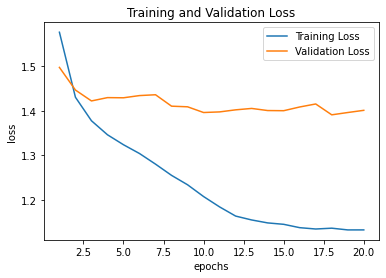

In [ ]:
import matplotlib.pyplot as plt
# line 1 points
x1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
y1 = training_loss_values
# plotting the line 1 points 
plt.plot(x1, y1, label = "Training Loss")
# line 2 points

y2 = validation_loss_values
# plotting the line 2 points 
plt.plot(x1, y2, label = "Validation Loss")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# Set a title of the current axes.
plt.title('Training and Validation Loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
y.pop()

tensor([0, 5, 5, 5, 5, 2, 0, 4, 1, 5, 0, 5, 5], device='cuda:0')

In [ ]:
prediction.pop()

tensor([0, 5, 5, 4, 5, 2, 0, 4, 1, 5, 0, 0, 5], device='cuda:0')

In [ ]:
y_tensor = torch.stack(y)
pred_tensor = torch.stack(prediction)

In [ ]:
true_y=y_tensor.cpu().detach().numpy()
pred_y=pred_tensor.cpu().detach().numpy()

In [ ]:
true_y.shape

(41, 16)

In [ ]:
pred_y=pred_y.flatten()

In [ ]:
true_y=true_y.flatten()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

                        precision    recall  f1-score   support

            Background       0.70      0.62      0.66       240
Comparison or Contrast       0.69      0.63      0.66       187
               Extends       0.37      0.47      0.41        32
                Future       0.38      0.53      0.44        17
            Motivation       0.39      0.61      0.47        56
                  Uses       0.74      0.72      0.73       124

              accuracy                           0.63       656
             macro avg       0.54      0.60      0.56       656
          weighted avg       0.66      0.63      0.64       656



In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

In [ ]:
cf_matrix

array([[150,  28,  11,   3,  37,  11],
       [ 35, 118,   7,   7,  12,   8],
       [  4,   3,  15,   1,   1,   8],
       [  4,   1,   0,   9,   1,   2],
       [ 11,   9,   0,   0,  34,   2],
       [  9,  11,   8,   4,   3,  89]])

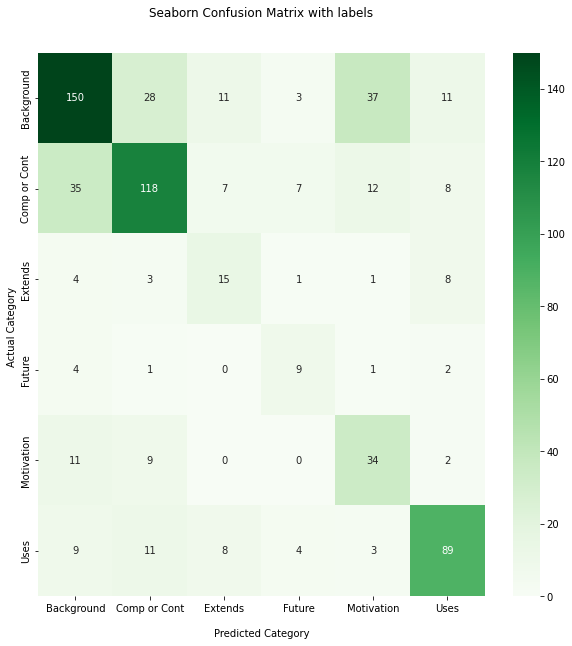

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Background","Comp or Cont","Extends","Future","Motivation","Uses"])
ax.yaxis.set_ticklabels(["Background","Comp or Cont","Extends","Future","Motivation","Uses"])

## Display the visualization of the Confusion Matrix.
plt.show()

**Testing**

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
tot_pred=[]
tot_labels=[]
input_ids=[]

for batch in test_dataloader:
        
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_citseg_id = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # It gives logits when labels are not given to model
        outputs = model(b_input_ids, 
                        b_input_mask, labels = None, citseg_id=b_citseg_id)
    
    # Get the "logits" output by the model. The "logits" are the output
    #logits = outputs
    _, logits = outputs.max(dim=1)
    tot_pred.append(logits)
    tot_labels.append(b_labels)
    input_ids.append(b_input_ids)

In [ ]:
tot_labels.pop()

tensor([1, 1, 0, 1, 0, 0, 5, 1, 4, 0, 5, 5], device='cuda:0')

In [ ]:
tot_pred.pop()

tensor([1, 1, 0, 0, 4, 0, 5, 1, 4, 0, 1, 2], device='cuda:0')

In [ ]:
input_ids.pop()

tensor([[ 102,  407,  545,  ...,    0,    0,    0],
        [ 102,  111,  545,  ...,    0,    0,    0],
        [ 102,  256,  469,  ...,    0,    0,    0],
        ...,
        [ 102,  106, 3966,  ...,    0,    0,    0],
        [ 102,  106,  475,  ...,    0,    0,    0],
        [ 102,  982,    1,  ...,    0,    0,    0]], device='cuda:0')

In [ ]:
tot_labels_tensor = torch.stack(tot_labels)
tot_pred_tensor = torch.stack(tot_pred)
input_ids_tensor=torch.stack(input_ids)

In [ ]:
true_y=tot_labels_tensor.cpu().detach().numpy()
pred_y=tot_pred_tensor.cpu().detach().numpy()
input_id=input_ids_tensor.cpu().detach().numpy()

In [ ]:
sent=[]
for i in (input_ids_tensor):
  for j in i:
    x=tokenizer.convert_ids_to_tokens(j)
    #print(x)
    sent.append(x)

In [ ]:
pred_y=pred_y.flatten()

In [ ]:
true_y=true_y.flatten()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Background","Comparison or Contrast","Extends","Future","Motivation","Uses"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

                        precision    recall  f1-score   support

            Background       0.66      0.75      0.70       117
Comparison or Contrast       0.72      0.63      0.67        90
               Extends       0.50      0.75      0.60        16
                Future       0.60      0.38      0.46         8
            Motivation       0.42      0.37      0.39        27
                  Uses       0.76      0.66      0.71        62

              accuracy                           0.66       320
             macro avg       0.61      0.59      0.59       320
          weighted avg       0.67      0.66      0.66       320



In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

In [ ]:
cf_matrix

array([[88, 11,  2,  2,  9,  5],
       [22, 57,  1,  0,  4,  6],
       [ 1,  1, 12,  0,  0,  2],
       [ 3,  0,  1,  3,  1,  0],
       [13,  4,  0,  0, 10,  0],
       [ 7,  6,  8,  0,  0, 41]])

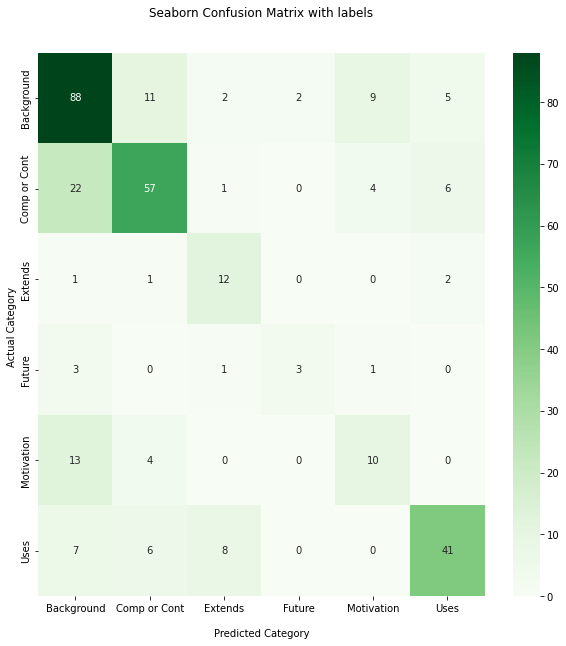

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Background","Comp or Cont","Extends","Future","Motivation","Uses"])
ax.yaxis.set_ticklabels(["Background","Comp or Cont","Extends","Future","Motivation","Uses"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
df=pd.DataFrame()
df['Actual Label']= true_y
df['Tokenised Text']=sent
df['predictions']= pred_y

In [ ]:
df['predictions']=df['predictions'].replace({0:"Background",1:"Comp or Cont", 2:"Extends", 3:"Future", 4:"Motivation", 5:"Uses"})
df['Actual Label']= df['Actual Label'].replace({0:"Background",1:"Comp or Cont", 2:"Extends", 3:"Future", 4:"Motivation", 5:"Uses"})

In [ ]:
df

,Actual Label,Tokenised Text,predictions
0,Comp or Cont,"[[CLS], though, several, studies, with, similar, objectives, have, been, reported, [, CITSEG, ], ,, [, CITSEG, ], ,, [, CITSEG, ], ,, [, CITSEG, ], ,, [, CITSEG, ], ,, [, CITSEG, ], ,, they, require, that, sample, corpora, be, correctly, analyzed, or, tagged, in, advance, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [...",Comp or Cont
1,Comp or Cont,"[[CLS], "", CITSEG, and, church, &, han, ##ks, (, 1990, ), describe, algorithms, which, do, this, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...",Background
2,Uses,"[[CLS], we, used, a, discriminative, word, alignment, model, (, dw, ##a, ), to, generate, the, alignments, as, described, in, CITSEG, instead, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]...",Uses
3,Motivation,"[[CLS], lexical, ##ist, approaches, to, mt, ,, particularly, those, incorporating, the, technique, of, sha, ##ke, -, and, -, bak, ##e, generation, (, CITSEG, ), ,, combine, the, linguistic, advantages, of, transfer, (, CITSEG, ), and, inter, ##ling, ##ual, (, CITSEG, ), approaches, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]...",Background
4,Comp or Cont,"[[CLS], most, other, work, on, clustering, for, language, modeling, (, e, ., g, ., CITSEG, ), has, addressed, the, problem, of, data, sparse, ##ness, by, clustering, words, into, classes, which, are, then, used, to, predict, smoothed, probabilities, of, occurrence, for, events, which, may, seldom, or, never, have, been, observed, during, training, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [...",Background
5,Motivation,"[[CLS], while, it, is, possible, to, transfer, much, of, the, present, proposal, to, the, transducer, -, based, setting, that, is, often, preferred, nowadays, ,, the, monos, ##tra, ##tal, approach, still, offers, an, attractive, alternative, due, to, its, easy, blend, with, monos, ##tra, ##tal, grammars, such, as, hp, ##sg, and, the, good, prospects, for, machine, learning, of, its, surface, #...",Background
6,Uses,"[[CLS], to, create, and, train, our, core, ##ference, resolve, ##r, ,, we, used, a, combination, of, techniques, as, outlined, originally, by, (, CITSEG, ), and, subsequently, extended, by, (, CITSEG, ), ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], ...",Uses
7,Comp or Cont,"[[CLS], the, comparison, that, CITSEG, performed, between, abstracts, and, citi, ##ng, sentences, suggests, that, a, summary, generated, from, citi, ##ng, sentences, will, be, different, and, probably, more, concise, and, informative, than, the, paper, abstract, or, a, summary, generated, from, the, full, text, of, the, paper, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [...",Comp or Cont
8,Comp or Cont,"[[CLS], based, on, this, advis, ##e, (, CITSEG, ), exclude, the, latent, segmentation, variables, and, opt, for, a, heuristic, training, procedure, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], ...",Background
9,Background,"[[CLS], CITSEG, then, report, a, 75, %, accuracy, for, an, algorithm, that, approximates, lap, ##pin, and, le, ##ass, ',